# Stefano Talamona (822452) - Assignment 1: Predicting Default Payments with Fully-Connected NNs


---
---

In [ ]:
# Connect to Drive to get the .csv files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics



---



## Loading the data

The dataset is composed of three different csv files and contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. 

In [29]:
# Load data from .csv files
def load_data(path, load_labels = False):
    df = pd.read_csv(path)
    X = df.values.copy()
    if load_labels:
        labels = X[:, 1 :].astype(str)
        return labels
    else:
        X = X[:, 1 :].astype(np.float32)
        return X

path_train = '/content/drive/MyDrive/data/X_train.csv'
path_test = '/content/drive/MyDrive/data/X_test.csv'
path_labels_train = '/content/drive/MyDrive/data/y_train.csv'
X_train = load_data(path_train, load_labels = False)
X_test = load_data(path_test, load_labels = False)
y_train = load_data(path_labels_train, load_labels = True)

print("Data correctly loaded from .csv files")

Data correctly loaded from .csv files




---



##Inspecting the data

The data dimensionality is shown in the output of the cell below. Most of the features are represented by continuous variables (LIMIT_BAL, BILL_AMT* , PAY_AMT* ), while others are categorical (SEX, EDUCATION, MARRIAGE, PAY*) and discrete (AGE).




In [ ]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Total number of features:", X_train.shape[1], "\n")
# Example of data
print("First raw of the dataset:\n", X_train[0].astype(int))

Training set shape: (24000, 23)
Test set shape: (6000, 23)
Total number of features: 23 

First raw of the dataset:
 [80000     2     2     2    24     0     0     0     0     0     0 75125
 77353 78321 73731 39643 39457  3503  5001  2092  1218  1445   878]


---

## Preprocessing

Since the presence of continuous and discrete/categorical variables, it makes even more sense to normalize all these values by removing the mean and scaling to unit variance in order to have all of them on the same scale (using the "MinMaxScaler" scaler provided by scikit-learn). This decision was taken because no further analysis (PCA for example) is required for the assignment, and this normalization step seems to be some sort of standard procedure in most of the implementations of ML models. 

This is in part the same reason why I decided to keep all of the 23 features (which may actually even result in a non-optimal choice if further analysis on the data would be performed). The other reason why I kept them all is because the number of features seems reasonable given the size of the dataset.

I also specified the argument "stratify" in function "train_test_split" which, if fed the y, it will ensure the same number of samples for each class are in training set and test (validation) set proportionally.

In [30]:
def preprocess_data(X, scaler = None):
    # Standardise features by removing the mean and scaling to unit variance
    if not scaler:
        scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

n_classes = 2
n_features = X_train.shape[1]
scaler = MinMaxScaler()
X_train, scaler = preprocess_data(X_train, scaler)
X_test, scaler = preprocess_data(X_test, scaler)
print("Scaler used to scale train and test sets:", scaler)

# The following conversion is carried out using one-hot encoding
Y_train = np_utils.to_categorical(y_train, n_classes)

print("\nDivide into training and validation:")
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, stratify = Y_train)
print("Training set size =", X_train.shape[0])
print("Validation set size =", X_val.shape[0])

Scaler used to scale train and test sets: MinMaxScaler(copy=True, feature_range=(0, 1))

Divide into training and validation:
Training set size = 18000
Validation set size = 6000


There is some disparity in the distribution of positive and negative samples, but not too strong to require a rebalance (even if bringing it to a more balanced distribution would be preferred, like 65% - 35%).

In [31]:
n_labels = Y_train.sum(axis = 0)
print("Number of negative samples =", int(n_labels[0]))
print("Number of positive samples =", int(n_labels[1]))
tot = n_labels[0] + n_labels[1]
print("The distribution is:")
print(round(100 / tot * n_labels[0], 2), "% = negative")
print(round(100 / tot * n_labels[1], 2), "% = positive")

Number of negative samples = 14008
Number of positive samples = 3992
The distribution is:
77.82 % = negative
22.18 % = positive




---



## Building the network

Taking as example the NNs built in the previous lab activities, the structure of the NN that I implemented can be summed up like this:

**FC@256+ReLU ---> FC@64+ReLU ---> FC@16+ReLU ---> FC@n_classes+sigmoid**

Because we are dealing with fully connected neural networks, all the layers in the model are Dense() objects.
I decided to add a dropout probability of 0.5 (chosen after a few tries with different probabilities) after each hidden layer, since the first results showed a **strong overfitting** behaviour of the model. For the same reason I restricted both the number and dimensions of the layers in the original structure I used in the first try, which was:

FC@512+ReLU ---> FC@256+ReLU---> FC@128+ReLU ---> FC@64+ReLU ---> FC@32+ReLU ---> FC@n_classes+sigmoid

For the hyperparameter '*optimizer*' I considered all the optimizers available in Keras, and based on the descriptions given on the [documentation](https://keras.io/api/optimizers/), I tried a few of them with different values for the learning rate, starting from the default value 0.001 and increasing/decreasing it by 100% a few times (usually getting worse results in the training metrics considered). 
First I decided to go for the Adam optimizer, which is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. Since according to [Kingma et al., 2014](https://arxiv.org/abs/1412.6980) Adam optimizer is "well suited for problems that are large in terms of data/parameters", and our problem is not that large in terms of data/parameters (not that much data examples and not that deep network), this did not seem to be the best choice, but once i tried to use other optimizers, for example RMSprop, i did not get any effect on the behaviour of the model, and i noticed just a tiny decrease in the performance metrics (less than 1% in accuracy). I ultimately decided to go for the Adam optimizer with standard learning rate value.

The initializer used here is the same used during the lab activities (GlorotUniform), since varing this hyperparameter did not seem to have strong effects on the results.

The activation function used in each layer is the widely used Rectified Linear Unit (ReLU), except of course for the output layer where, since we are dealing with a binary classification problem, I chose to use the Logistic Function (sigmoid). 

The training metric I considered is the binary accuracy, which is used to compute the mean accuracy rate across all predictions for binary classification problems.

Last but not least, I used the BinaryCrossentropy as loss function, since it is meant to be used in binary classification applications like this one.

In [32]:
initializer = initializers.GlorotUniform(seed = 1234)
#optimizer = optimizers.SGD(learning_rate = 0.001)
optimizer = optimizers.Adam(learning_rate = 0.001)
#optimizer = optimizers.RMSprop(learning_rate = 0.001)

model = Sequential()
""" FC@256+ReLU """
model.add(Dense(256, activation = "relu", kernel_initializer = initializer))
model.add(Dropout(rate = 0.5))
""" FC@64+ReLU """
model.add(Dense(64, activation = "relu", kernel_initializer = initializer))
model.add(Dropout(rate = 0.5))
""" FC@16+ReLU """
model.add(Dense(16, activation = "relu", kernel_initializer = initializer))
model.add(Dropout(rate = 0.5))
""" FC@n_classes+sigmoid """
model.add(Dense(n_classes, activation = "sigmoid", kernel_initializer = initializer))

n_epochs = 25
batch_size = 128

model.compile(optimizer = optimizer, loss = "binary_crossentropy",
              metrics = metrics.CategoricalAccuracy(name = 'accuracy'))

In [33]:
# Start training
network_history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = n_epochs, verbose = 1)
print("\n\nTraining complete!")

Epoch 1/25
141/141 [==============================] - 2s 4ms/step - loss: 0.5570 - accuracy: 0.7698
Epoch 2/25
141/141 [==============================] - 1s 4ms/step - loss: 0.5091 - accuracy: 0.7816
Epoch 3/25
141/141 [==============================] - 1s 4ms/step - loss: 0.4957 - accuracy: 0.7998
Epoch 4/25
141/141 [==============================] - 1s 4ms/step - loss: 0.4799 - accuracy: 0.8019
Epoch 5/25
141/141 [==============================] - 1s 4ms/step - loss: 0.4766 - accuracy: 0.8049
Epoch 6/25
141/141 [==============================] - 1s 4ms/step - loss: 0.4691 - accuracy: 0.8086
Epoch 7/25
141/141 [==============================] - 1s 4ms/step - loss: 0.4678 - accuracy: 0.8082
Epoch 8/25
141/141 [==============================] - 1s 4ms/step - loss: 0.4624 - accuracy: 0.8057
Epoch 9/25
141/141 [==============================] - 1s 4ms/step - loss: 0.4607 - accuracy: 0.8078
Epoch 10/25
141/141 [==============================] - 1s 4ms/step - loss: 0.4596 - accuracy: 0.8078



---



## Training results

As can be seen by executing the code in the cell below, the model performed decently in the training step, obtaining a percentage of approximately 81% in accuracy, value which is also consistent with the other metrics considered (see the part about validation). 

A plot is also produced in order to give a graphical visualization of the trend of loss and accuracy during each epoch. In both of these it can be seen how these trends tend to converge around some values at the end of the training step. The study of these plots has been fundamental to chose an appropriate value for the number of epochs. At first, I tried with 100 epochs, which gave better results in terms of accuracy. Incrementing by 100 epochs each time, I had been able to obtain even better results, reaching almost 98% in accuracy with 500 epochs (**NOTE**: this is referred to the first model already discussed in the previous text cell). Anyway, after a few changes in the network architecture, the loss seemed to converge much sooner than 500 epochs (even sooner than 100), so I tried to decrease the number of epochs dropping it to 25.

In [34]:
# Show results
accuracy = network_history.history["accuracy"][-1]
print("Accuracy =", accuracy)

Accuracy = 0.8084999918937683


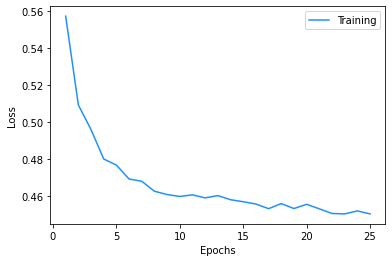

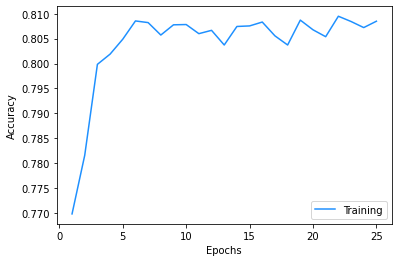

In [35]:
# Plot results
x_plot = list(range(1, n_epochs + 1))
# Loss
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x_plot, network_history.history['loss'], color = "dodgerblue")
plt.legend(['Training'])
# Accuracy
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(x_plot, network_history.history['accuracy'], color = "dodgerblue")
plt.legend(['Training'], loc='lower right')
plt.show()



---



## Model validation

The process of validation is the same shown during the lab activities, with the only difference being the number of metrics considered. In order to understend how well the model performed during validation, I decided to use the following metrics:
*   BinaryAccuracy;
*   Precision;
*   Recall;
*   F1 score;

These can be seen to be very consistent with each other, giving a reason to believe that even though the performance is not that extraordinary itself, there is no sign of inbalance between the classification of positive and negative examples.

As I said before, I tried different optimizers, initializers, number of epochs and number/dimension for the hidden layers, reaching an accuracy of almost 98% in some cases. Unfortunately, these promissing results were made possible only with a ridiculous ammount of overfitting, which was impossible to not notice from the graphs of training/validation loss/accuracy. In fact, validation loss kept on growing while its accuracy decreased, and the opposite for the training data. The trends looked almost simmetrical, leaving no doubts about the presence of heavy overfitting. 

I ultimately decided to try my best to remove the overfitting phenomenon, even at the cost of a much lower accuracy level (since it would not make that much sense to reach 99% of accuracy in the training set if this kind of result cannot be replicated on any other set of the same data). This is the main motivation behind the decisions discussed above.

In [36]:
metrics = [
      metrics.BinaryAccuracy(name = 'accuracy'),
      metrics.Precision(name = 'precision'),
      metrics.Recall(name = 'recall')
]
model.compile(optimizer = optimizer, loss = "binary_crossentropy",
              metrics = metrics)

# Train and validate
network_history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = n_epochs,
                            verbose = 2, validation_data = (X_val, Y_val))

Epoch 1/25
141/141 - 1s - loss: 0.4498 - accuracy: 0.8084 - precision: 0.8089 - recall: 0.8076 - val_loss: 0.4413 - val_accuracy: 0.8188 - val_precision: 0.8191 - val_recall: 0.8182
Epoch 2/25
141/141 - 0s - loss: 0.4493 - accuracy: 0.8096 - precision: 0.8099 - recall: 0.8091 - val_loss: 0.4407 - val_accuracy: 0.8184 - val_precision: 0.8187 - val_recall: 0.8180
Epoch 3/25
141/141 - 1s - loss: 0.4497 - accuracy: 0.8094 - precision: 0.8099 - recall: 0.8088 - val_loss: 0.4432 - val_accuracy: 0.8197 - val_precision: 0.8199 - val_recall: 0.8193
Epoch 4/25
141/141 - 0s - loss: 0.4490 - accuracy: 0.8074 - precision: 0.8076 - recall: 0.8071 - val_loss: 0.4411 - val_accuracy: 0.8177 - val_precision: 0.8181 - val_recall: 0.8172
Epoch 5/25
141/141 - 1s - loss: 0.4480 - accuracy: 0.8108 - precision: 0.8111 - recall: 0.8101 - val_loss: 0.4399 - val_accuracy: 0.8190 - val_precision: 0.8191 - val_recall: 0.8188
Epoch 6/25
141/141 - 1s - loss: 0.4487 - accuracy: 0.8101 - precision: 0.8104 - recall: 0.

In [37]:
# Show results
print("Training:")
accuracy = network_history.history['accuracy'][-1]
precision = network_history.history['precision'][-1]
recall = network_history.history['recall'][-1]
print("Accuracy =", accuracy)
print("Precision =", precision)
print("Recall =", recall)
print("F1 score =", 2 * ((precision * recall) / (precision + recall)) ,"\n")

print("Validation:")
val_accuracy = network_history.history['val_accuracy'][-1]
val_precision = network_history.history['val_precision'][-1]
val_recall = network_history.history['val_recall'][-1]
print("Validation accuracy =", val_accuracy)
print("Validation precision =", val_precision)
print("Validation recall =", val_recall)
print("F1 score =", 2 * ((val_precision * val_recall) / (val_precision + val_recall)))

Training:
Accuracy = 0.8137778043746948
Precision = 0.813847541809082
Recall = 0.8136666417121887
F1 score = 0.8137570817070071 

Validation:
Validation accuracy = 0.8188333511352539
Validation precision = 0.8189396262168884
Validation recall = 0.8186666369438171
F1 score = 0.8188031088266711


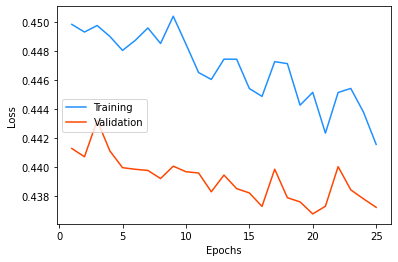

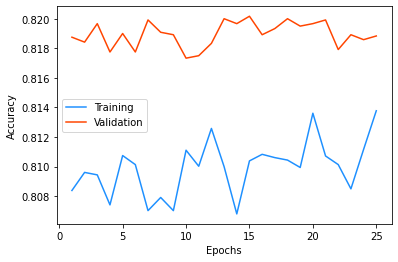

In [38]:
# Plot results
x_plot = list(range(1, n_epochs + 1))
# Loss
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x_plot, network_history.history['loss'], color = "dodgerblue")
plt.plot(x_plot, network_history.history['val_loss'], color = "orangered")
plt.legend(['Training', 'Validation'], loc = 6)
# Accuracy
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(x_plot, network_history.history['accuracy'], color = "dodgerblue")
plt.plot(x_plot, network_history.history['val_accuracy'], color = "orangered")
plt.legend(['Training', 'Validation'], loc = 6)
plt.show()

From the two plots just shown, there is no sign of over/underfitting, since the trend of the loss of the validation subset looks consistent with the one of the training (just shifted by a small offset). This shows a good generalization ability of the model.



---



## Making predictions on the provided test set

Given the results obtained during the validation process, since the model seems to have a good generalization ability, I think that the results of the testing on the provided test set will show pretty much the same values for the metrics considered as for the ones obtained during the previous step, with a level of accuracy around 80-82%.

In [40]:
predictions = model.predict(X_test)
print(predictions)
print("\nShape of the predicion vector:", predictions.shape)

[[0.77605075 0.22330937]
 [0.91208255 0.08816388]
 [0.84258795 0.15726668]
 ...
 [0.7294119  0.2699773 ]
 [0.78428864 0.2151576 ]
 [0.94879997 0.05151239]]

Shape of the predicion vector: (6000, 2)




---



# (OPTIONAL) Exporting the predictions in a .txt file

In [46]:
file_path = '/content/drive/MyDrive/data/Stefano_Talamona_822452_score2.txt'
f = open(file_path, "w")
for pred in predictions:
  f.write('0\n') if pred[0] > pred[1] else f.write('1\n')
f.close()

Looking at the text file produced, it can be seen that most of the predictions are negative ("no" = 0), which is consistent with the distribution shown in the *Preprocessing* section (even if of course this does not necessarly mean that the predictions themselves are correct). 



---



# (OPTIONAL) Regularization

Keras offers a set of regularizers, which can be applied in the following ways:
*   ***kernel_regularizer***: regularizer to apply a penalty on the layer's **kernel**;
*   ***bias_regularizer***: regularizer to apply a penalty on the layer's **bias**;
*   ***activity_regularizer***: regularizer to apply a penalty on the layer's **output**.

The regularizers that can be implemented are:
*   L1;
*   L2;
*   l1_l2 (applies both L1 and L2).

Keras also allows the user to implement its own custom regularizers (which I am not going to experiment in this assignment).

I decided to apply both L1 and L2 separately on the *kernel*, the *bias* and *activity*.

In [92]:
# Applying L1 regularization 
regularizer = regularizers.l1(l1 = 0.01)
model_l1 = Sequential()
model_l1.add(Dense(256, activation = "relu", kernel_initializer = initializer,
                kernel_regularizer = regularizer, bias_regularizer = regularizer, activity_regularizer = regularizer))
model.add(Dropout(rate = 0.5))
model_l1.add(Dense(64, activation = "relu", kernel_initializer = initializer,
                kernel_regularizer = regularizer, bias_regularizer = regularizer, activity_regularizer = regularizer))
model.add(Dropout(rate = 0.5))
model_l1.add(Dense(16, activation = "relu", kernel_initializer = initializer,
                kernel_regularizer = regularizer, bias_regularizer = regularizer, activity_regularizer = regularizer))
model.add(Dropout(rate = 0.5))
model_l1.add(Dense(n_classes, activation = "sigmoid", kernel_initializer = initializer))

model_l1.compile(optimizer = optimizer, loss = "binary_crossentropy",
              metrics = ['accuracy'])

# Applying L2 regularization
regularizer = regularizers.l2(l2 = 0.01)
model_l2 = Sequential()
model_l2.add(Dense(256, activation = "relu", kernel_initializer = initializer,
                kernel_regularizer = regularizer, bias_regularizer = regularizer, activity_regularizer = regularizer))
model.add(Dropout(rate = 0.5))
model_l2.add(Dense(64, activation = "relu", kernel_initializer = initializer,
                kernel_regularizer = regularizer, bias_regularizer = regularizer, activity_regularizer = regularizer))
model.add(Dropout(rate = 0.5))
model_l2.add(Dense(16, activation = "relu", kernel_initializer = initializer,
                kernel_regularizer = regularizer, bias_regularizer = regularizer, activity_regularizer = regularizer))
model.add(Dropout(rate = 0.5))
model_l2.add(Dense(n_classes, activation = "sigmoid", kernel_initializer = initializer))

model_l2.compile(optimizer = optimizer, loss = "binary_crossentropy",
              metrics = ['accuracy'])

In [93]:
# Running this cell will take approximately 20 seconds
network_history_l1 = model_l1.fit(X_train, Y_train, batch_size = batch_size, epochs = n_epochs,
                            verbose = 0, validation_data = (X_val, Y_val))
network_history_l2 = model_l2.fit(X_train, Y_train, batch_size = batch_size, epochs = n_epochs,
                            verbose = 0, validation_data = (X_val, Y_val))

In [94]:
# Results with L1 regularizer
accuracy = network_history_l1.history["accuracy"][-1]
print("Results obtained with L1 regularizer:")
print("Training accuracy =", accuracy)
val_accuracy = network_history_l1.history['val_accuracy'][-1]
print("Validation accuracy =", val_accuracy)
# Results with L2 regularizer
print("\nResults obtained with L2 regularizer:")
accuracy = network_history_l2.history["accuracy"][-1]
print("Training accuracy =", accuracy)
val_accuracy = network_history_l2.history['val_accuracy'][-1]
print("Validation accuracy =", val_accuracy)

Results obtained with L1 regularizer:
Training accuracy = 0.7782222032546997
Validation accuracy = 0.778166651725769

Results obtained with L2 regularizer:
Training accuracy = 0.8086110949516296
Validation accuracy = 0.8118333220481873


As can be seen, the L1 regularizer seems to generate worse results in terms of accuracy, while L2 gives approximately the same results.

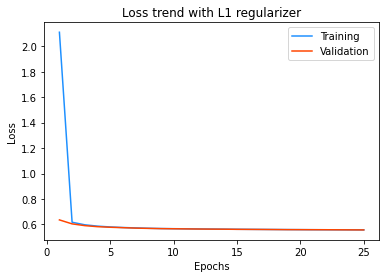

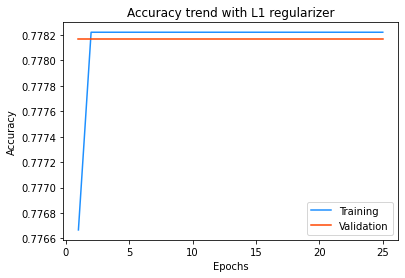

In [95]:
# Plot results obtained with L1 regularizer
x_plot = list(range(1, n_epochs + 1))
# Loss
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x_plot, network_history_l1.history['loss'], color = "dodgerblue")
plt.plot(x_plot, network_history_l1.history['val_loss'], color = "orangered")
plt.legend(['Training', 'Validation'])
plt.title("Loss trend with L1 regularizer")
# Accuracy
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(x_plot, network_history_l1.history['accuracy'], color = "dodgerblue")
plt.plot(x_plot, network_history_l1.history['val_accuracy'], color = "orangered")
plt.legend(['Training', 'Validation'], loc='lower right')
plt.title("Accuracy trend with L1 regularizer")
plt.show()

The plots about L1 show an unwanted behaviour for both loss and accuracy, since they seem to converge to fixed values after less than 10 epochs.

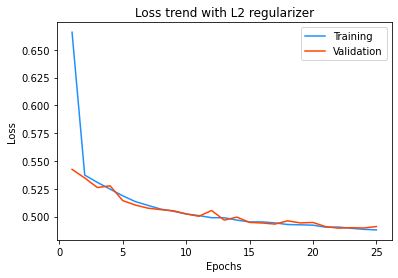

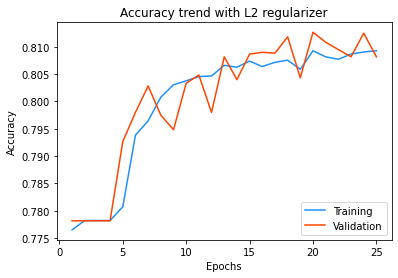

In [89]:
# Plot results obtained with L2 regularizer
x_plot = list(range(1, n_epochs + 1))
# Loss
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x_plot, network_history_l2.history['loss'], color = "dodgerblue")
plt.plot(x_plot, network_history_l2.history['val_loss'], color = "orangered")
plt.legend(['Training', 'Validation'])
plt.title("Loss trend with L2 regularizer")
# Accuracy
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(x_plot, network_history_l2.history['accuracy'], color = "dodgerblue")
plt.plot(x_plot, network_history_l2.history['val_accuracy'], color = "orangered")
plt.legend(['Training', 'Validation'], loc='lower right')
plt.title("Accuracy trend with L2 regularizer")
plt.show()

The plots about results obtained with L2 show a better correlation between the trends of both loss and accuracy respect to the original model without regularization, and of course these are much better results than the ones obtained with L1 regularizer, meaning that computing the penalty using the square() instead that the abs() is more suitable for this problem.



---

